# Saves Analysis

### MSP, 4.21.2017

A struggle to understand exactly what we can use, apart from manager proclamations, to understand save propensity.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


%matplotlib inline

In [3]:
# read in fangraphs-ripped stats. specifications:
#    fangraphs-denoted starter


def read_individual_standard_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","W","L","ERA","G","GS","CG","ShO",\
                                   "SV","HLD","BS","IP","TBF","H","R","ER","HR","BB",\
                                   "IBB","HBP","WP","BK","SO","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'i2','i2','i2','f4','i2','i2','i2','i2','i2','f4',\
                                    'f4','f4','f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')

def read_individual_battedball_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","BABIP","GB/FB","LD","GB","FB","IFFB","HRFB",\
                                   "RS","RS9","BLLS","STRKS","PIT","PULL","CENT","OPPO",\
                                   "SOFT","MED","HARD","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')


def read_individual_pfraction_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","IP",\
                                   "FA","FT","FC","FS","FO",\
                                   "SI","SL","CU","KC","EP",\
                                   "CH","SC","KN","UN","playerid"),\
                         'formats': ('S20','S20','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','i4')},\
                    skip_header=1,delimiter=',',filling_values=0.)

def read_individual_pvel_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","IP",\
                                   "vFA","vFT","vFC","vFS","vFO",\
                                   "vSI","vSL","vCU","vKC","vEP",\
                                   "vCH","vSC","vKN","playerid"),\
                         'formats': ('S20','S20','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','i4')},\
                    skip_header=1,delimiter=',',filling_values=0.)


RelieversPlayers2016 = read_individual_standard_stats('2016Pitching/Relievers2016.csv')
RelieversBatted2016  = read_individual_battedball_stats('2016Pitching/RelieversBatted2016.csv')

RelieversPitches2016 = read_individual_pfraction_stats('2016Pitching/RelieversPitchFractions.csv')
RelieversVelo2016 = read_individual_pvel_stats('2016Pitching/RelieversPitchVels.csv')




How does one succeed at being a closer?

How many saves can someone get?

In [4]:

#
# calculate some extra stats
#

#FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant


SP2016FIP  = (13.*RelieversPlayers2016['HR'] +\
              (3.*(RelieversPlayers2016['BB'] + RelieversPlayers2016['HBP'])) -\
              2.*RelieversPlayers2016['SO'])\
                /RelieversPlayers2016['IP'] + 3.1437 # 3.143 is the 2016 correction
    
SP2016WHIP = (RelieversPlayers2016['BB'] + RelieversPlayers2016['H'])/RelieversPlayers2016['IP']
SP2016HIP = (RelieversPlayers2016['H'])/RelieversPlayers2016['IP']




In [5]:


#
# match the player stats across datasets
#
PlayerDict = {}
PlayerDict['Player'] = RelieversPlayers2016['Name']
PlayerDict['WHIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['BABIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['FIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['HIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['ERA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['ST'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['fFA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['fSS'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['vFA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['vSS'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['SV'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['TSV'] = np.zeros(len(RelieversPlayers2016['Name']))




#
# also add a 100 IP threshold
#
for x in range(0,len(PlayerDict['Player'])):
    if RelieversPlayers2016['IP'][x] > 40.:
        PlayerDict['WHIP'][x] = SP2016WHIP[x]
        PlayerDict['FIP'][x] = SP2016FIP[x]
        PlayerDict['HIP'][x] = SP2016HIP[x]
        PlayerDict['ERA'][x] = RelieversPlayers2016['ERA'][x]
        PlayerDict['SV'][x] = RelieversPlayers2016['SV'][x]/RelieversPlayers2016['G'][x]
        PlayerDict['TSV'][x] = RelieversPlayers2016['SV'][x]
        # block for velocities
        xx = np.where(RelieversPlayers2016['Name'][x] == RelieversPitches2016['Name'])[0]
        xv = np.where(RelieversPlayers2016['Name'][x] == RelieversVelo2016['Name'])[0]
        try:
            PlayerDict['fFA'][x] = \
              RelieversPitches2016['FA'][xx] + RelieversPitches2016['FT'][xx] + \
                RelieversPitches2016['FC'][xx] + RelieversPitches2016['FS'][xx] + \
                RelieversPitches2016['FO'][xx]
            PlayerDict['vFA'][x] = \
              np.max([RelieversVelo2016['vFA'][xv],RelieversVelo2016['vFT'][xv],\
                      RelieversVelo2016['vFC'][xv],RelieversVelo2016['vFS'][xv],\
                      RelieversVelo2016['vFO'][xv]])
            PlayerDict['fSS'][x] = \
              RelieversPitches2016['SI'][xx] + RelieversPitches2016['SL'][xx]
            PlayerDict['vSS'][x] = \
              np.max([RelieversVelo2016['vSI'][xv],RelieversVelo2016['vSL'][xv]])

        except:
            PlayerDict['FA'][x] = np.nan
            PlayerDict['vFA'][x] = np.nan
            PlayerDict['SS'][x] = np.nan
            PlayerDict['vSS'][x] = np.nan
            
        try:
            xx = np.where(RelieversPlayers2016['Name'][x] == RelieversBatted2016['Name'])[0]
            PlayerDict['BABIP'][x] = \
              RelieversBatted2016['BABIP'][xx]
            PlayerDict['ST'][x] = RelieversBatted2016['STRKS'][xx]/RelieversBatted2016['PIT'][xx]
        except:
            PlayerDict['BABIP'][x] = np.nan
            PlayerDict['ST'][x] = np.nan
            
        
    else:
        PlayerDict['WHIP'][x] = np.nan
        PlayerDict['FIP'][x] = np.nan
        PlayerDict['HIP'][x] = np.nan
        PlayerDict['BABIP'][x] = np.nan

Alright, let's get a couple things straight first by looking at the distribution of saves in 2016. 90 guys got 1+ save, but only 12 got 32+. In fact, looking at the cumulative distribution, the top 12 closers got 50% of the available saves--and no league has 100% save efficiency (the guys who are down below 5 are unlikely to ever be owned).

In fact, we can take a stab at estimating what the save efficiency in a league is by looking at the saves-per-appearance plot. Going off gut feeling, I'd say it's unlikely that guys who get less than 1 save per 10 appearances are owned, which according to the cumulative distribution function, suggests that almost 20% of the saves in the MLB go unrecorded in the average fantasy league. Damn.

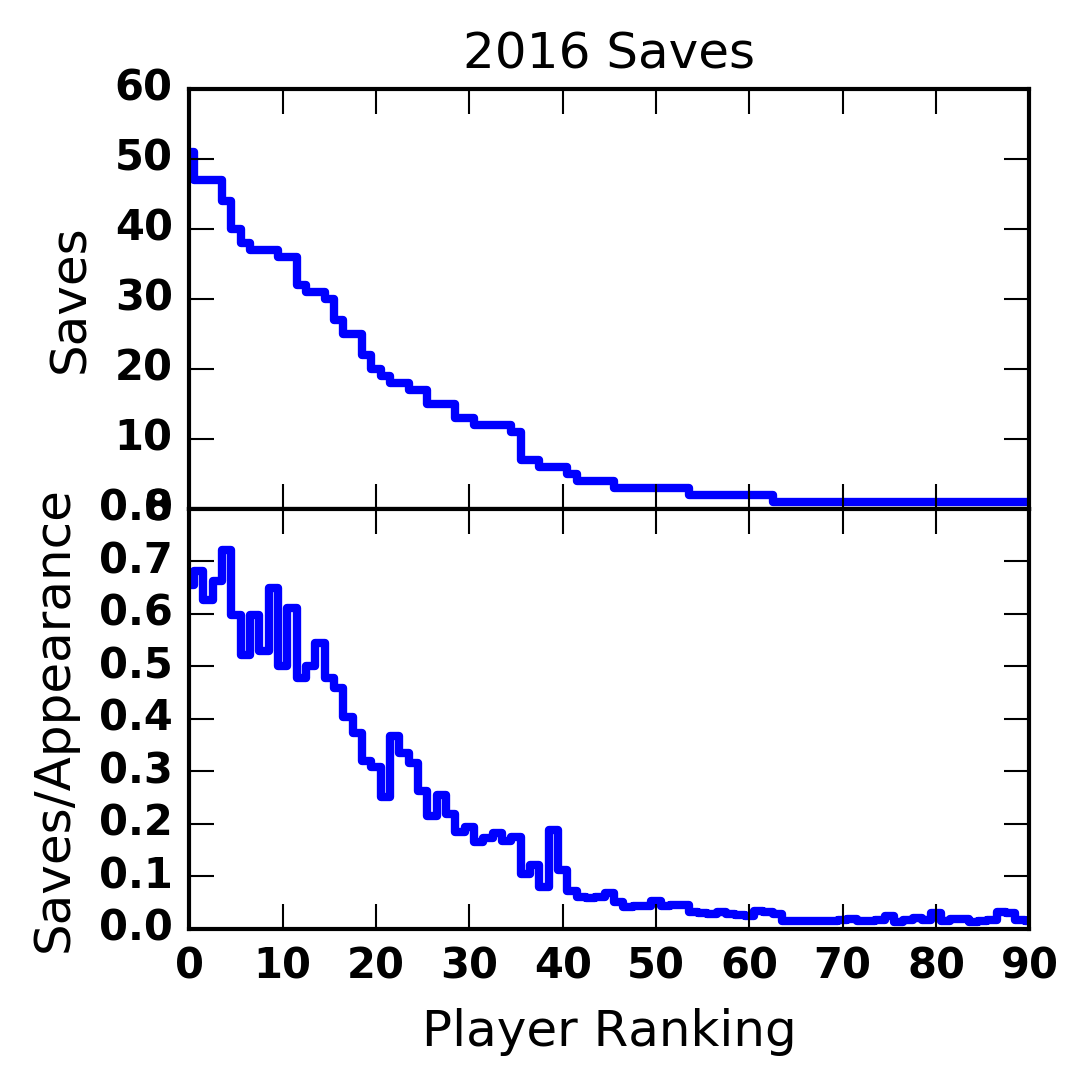

In [6]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_axes([0.15,0.5,0.7,0.35])
ax2 = fig.add_axes([0.15,0.15,0.7,0.35])




ax2.plot(PlayerDict['SV'][(-1.*PlayerDict['TSV']).argsort()[0:91]],drawstyle='steps-mid')
ax2.set_ylabel('Saves/Appearance',size=12)
ax2.set_xlabel('Player Ranking',size=12)



ax.plot(PlayerDict['TSV'][(-1.*PlayerDict['TSV']).argsort()[0:91]],drawstyle='steps-mid')
ax.set_ylabel('Saves',size=12)
ax.set_title('2016 Saves')
_ = ax.set_xticklabels(())




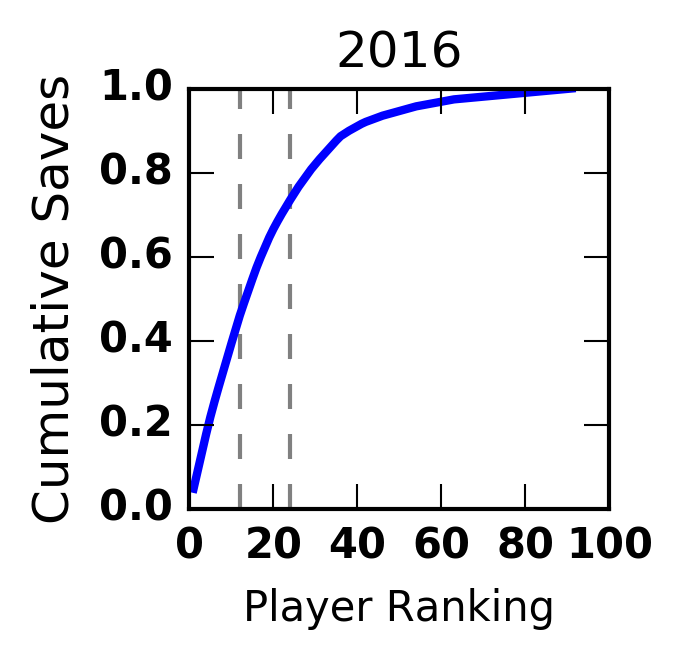

In [7]:
fig = plt.figure(figsize=(2,2))

ax = fig.add_axes([0.15,0.5,0.7,0.7])

ax.plot([12,12],[0.,1.],color='gray',lw=1.,linestyle='dashed')
ax.plot([24,24],[0.,1.],color='gray',lw=1.,linestyle='dashed')



ax.plot(np.arange(1,92,1),np.cumsum(PlayerDict['TSV'][(-1.*PlayerDict['TSV']).argsort()[0:91]])/np.sum(PlayerDict['TSV']))
ax.set_ylabel('Cumulative Saves',size=12)
ax.set_title('2016',size=12)


_ = ax.set_xlabel('Player Ranking')



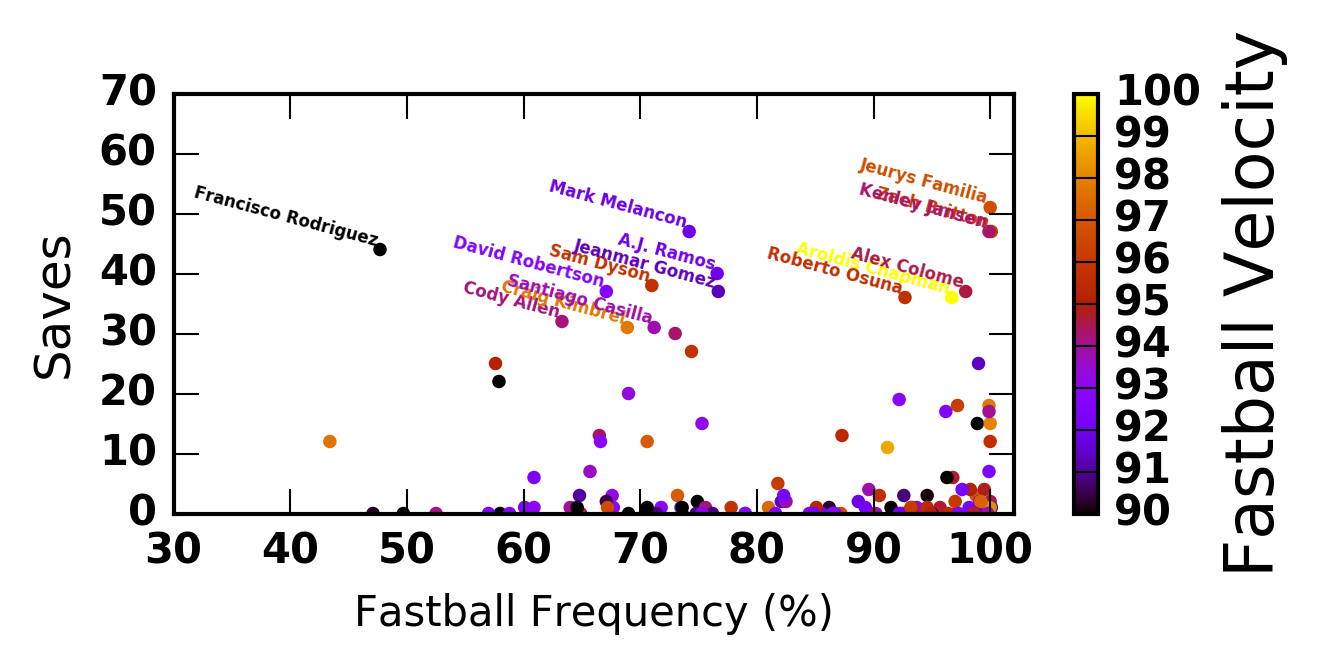

In [8]:

fig = plt.figure(figsize=(4,2))

ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find valid values and plot
ax.scatter(PlayerDict['fFA']+PlayerDict['fSS'],PlayerDict['TSV'],\
            color=cm.gnuplot((np.max([PlayerDict['vFA'],PlayerDict['vSS']],axis=0) - 90.)/10.,1.),s=5.)

ax.set_ylabel('Saves',size=12)
ax.set_xlabel('Fastball Frequency (%)')

ax.axis([30,102,0,70])

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=90., vmax=100.)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Fastball Velocity',size=16)


for indx in range(0,len(PlayerDict['TSV'])):
    if (PlayerDict['TSV'][indx] >= 31):
        ax.text(PlayerDict['fFA'][indx]+PlayerDict['fSS'][indx],\
                PlayerDict['TSV'][indx],PlayerDict['Player'][indx],size=4,rotation=-15,ha='right',va='bottom',color=cm.gnuplot((np.max([PlayerDict['vFA'][indx],PlayerDict['vSS'][indx]],axis=0) - 90.)/10.,1.))






So... you don't have to throw hard to be a closer. But, in general it takes a good fastballer to get there. If you don't throw hard, you've got to mix it up.

I'm interpreting this as meaning that placement (control) matters. This is similar to the realization from the ERA/WHIP analysis previously.

Quick hits:
1. **K-Rod** is dangerous. <50% fastballs at <90 MPH? Should not be working.
2. **Juerys Familia** is a dirtbag; he's got **Zach Britton+Kenley Jansen+Roberto Osuna+ Aroldis Chapman** profile. (other guys with this profile: *Miller, Iglesias, Edwin Diaz,Kintzler, Gregerson, Joe Smith, Tony Cingrani, Giles, Grilli, Cishek, Nate Jones?? Jake Diekman??*)
3. **Alex Colome** and **Hector Neris** are their own men: ALL FASTBALLS ALL THE TIME
4. The mixed guys: **Melancon, Casilla, Kimbrel, Allen, Ramos, Gomez, Dyson, Robertson**. These guys could go cold pretty quick if their stuff isn't working.

ERA-WHIP Parameters
-------------------
('Slope=', 0.13915686973722888)
('Intercept=', 0.75794653206700968)


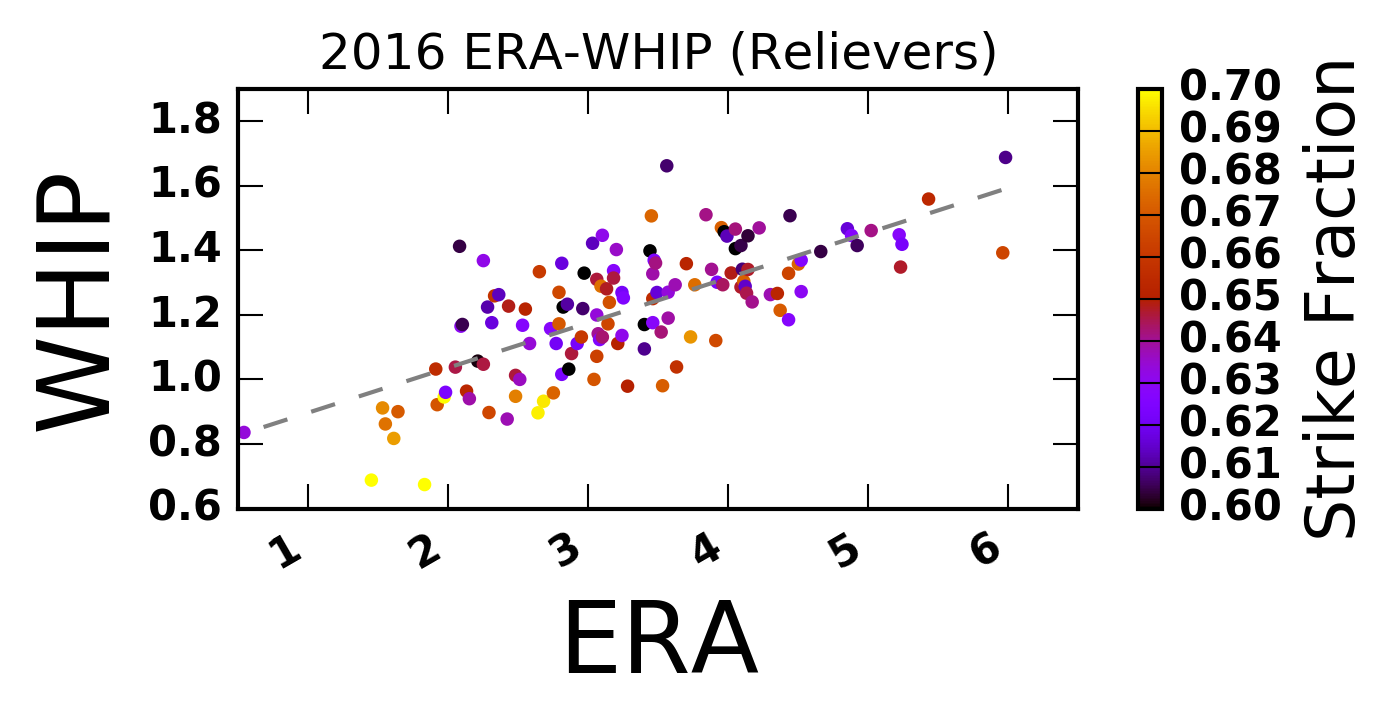

In [9]:

fig = plt.figure(figsize=(4,2))

ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find valid values and plot
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]
ax.scatter(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],\
            color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


ax.axis([0.5,6.5,0.6,1.9])
ax.set_ylabel('WHIP',size=24)
ax.set_xlabel('ERA',size=24)
for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

ax.set_title('2016 ERA-WHIP (Relievers)')



# fit a linear model to valid values
goodw = np.where(PlayerDict['ERA'] > 0.)[0]
c = np.polyfit(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],1)
d = np.poly1d(c)
ax.plot(np.linspace(0.0,6.0,100),d(np.linspace(0.0,6.0,100)),color='gray',lw=1.,linestyle='dashed')

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=16)


print('ERA-WHIP Parameters')
print('-------------------')
print('Slope=',c[0])
print('Intercept=',c[1])





Starter ERA-WHIP Parameters:

('Slope=', 0.162)
('Intercept=', 0.628)

What does it mean that these values are (modestly) different?

Fitted ERA-BABIP Parameters
-------------------
('Slope=', 13.372)
('Intercept=', -0.48999999999999999)

Used ERA-BABIP Parameters
-------------------
Slope= 20.0
Intercept= -1.9


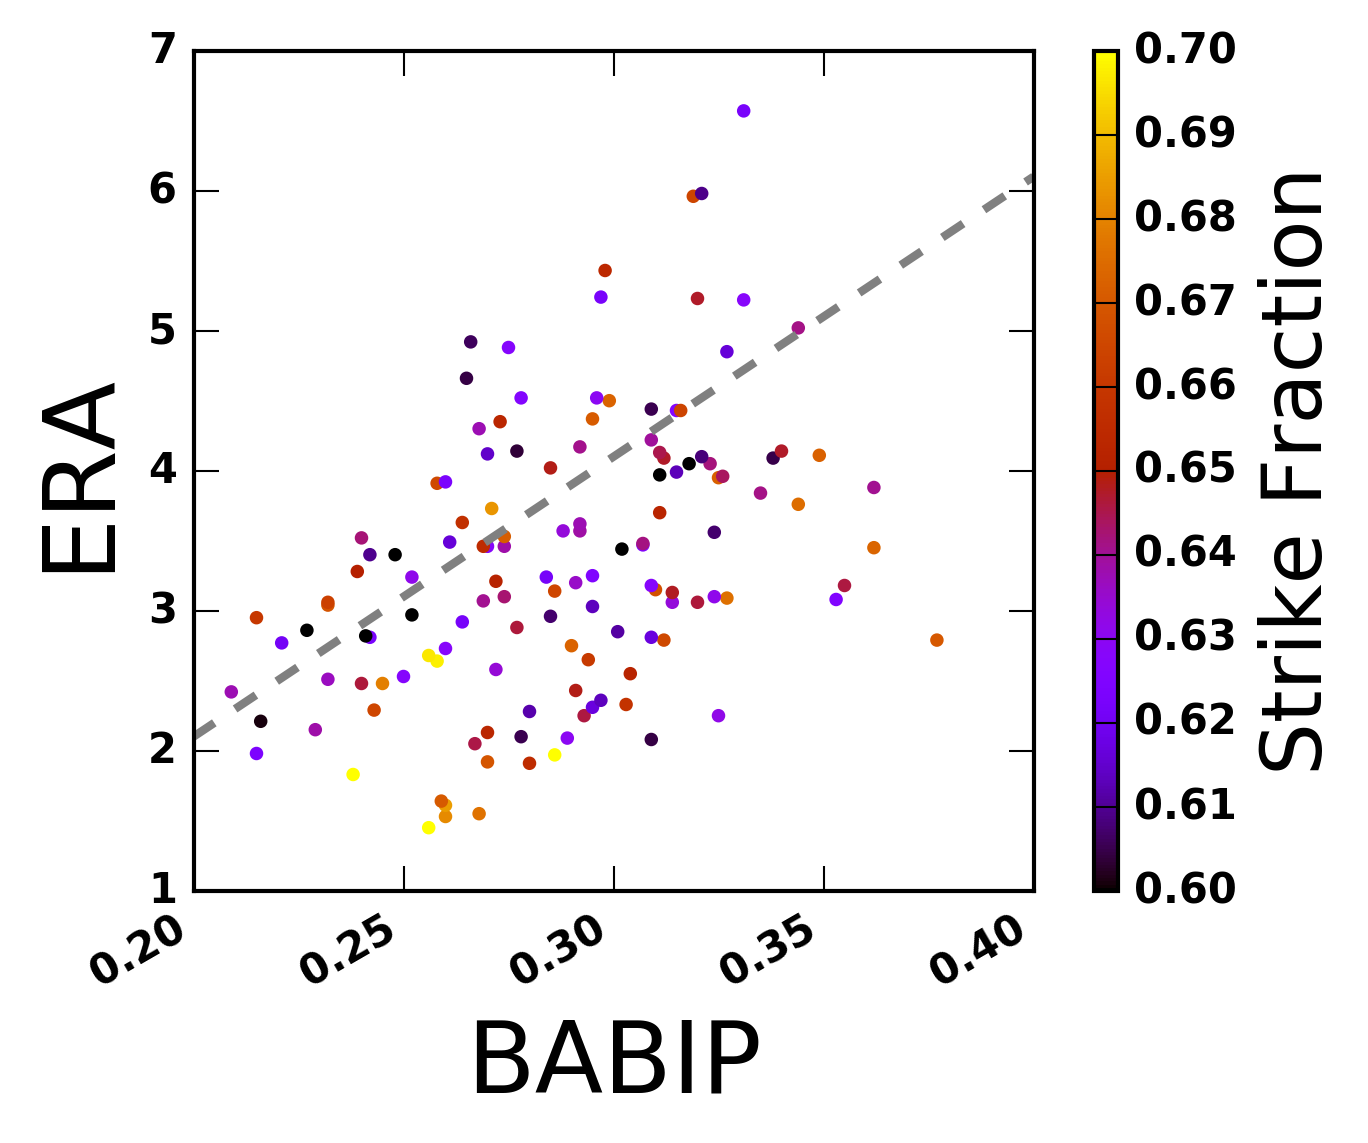

In [10]:


fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find only pitchers with batted ball data
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]

ax.scatter(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

c = np.polyfit(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],1)
print('Fitted ERA-BABIP Parameters')
print('-------------------')
print('Slope=',np.round(c[0],3))
print('Intercept=',np.round(c[1],2))




# override with old parameters
c = [20.,-1.9]
d = np.poly1d(c)

print
print('Used ERA-BABIP Parameters')
print('-------------------')
print'Slope=',np.round(c[0],3)
print'Intercept=',np.round(c[1],2)




ax.plot(np.linspace(.2,.4,100),d(np.linspace(.2,.4,100)),color='gray',linestyle='dashed')

ax.axis([0.2,0.4,1.,7.])
ax.set_ylabel('ERA',size=24)
ax.set_xlabel('BABIP',size=24)

for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")


I cheated a little bit above and forced the line from the Starters to fit the Relievers. I think there is a future exploration to be had there, but for now, I want to evaluate them on a level playing field for BABIP-ERA (as the ERA-WHIP) is not particularly different.

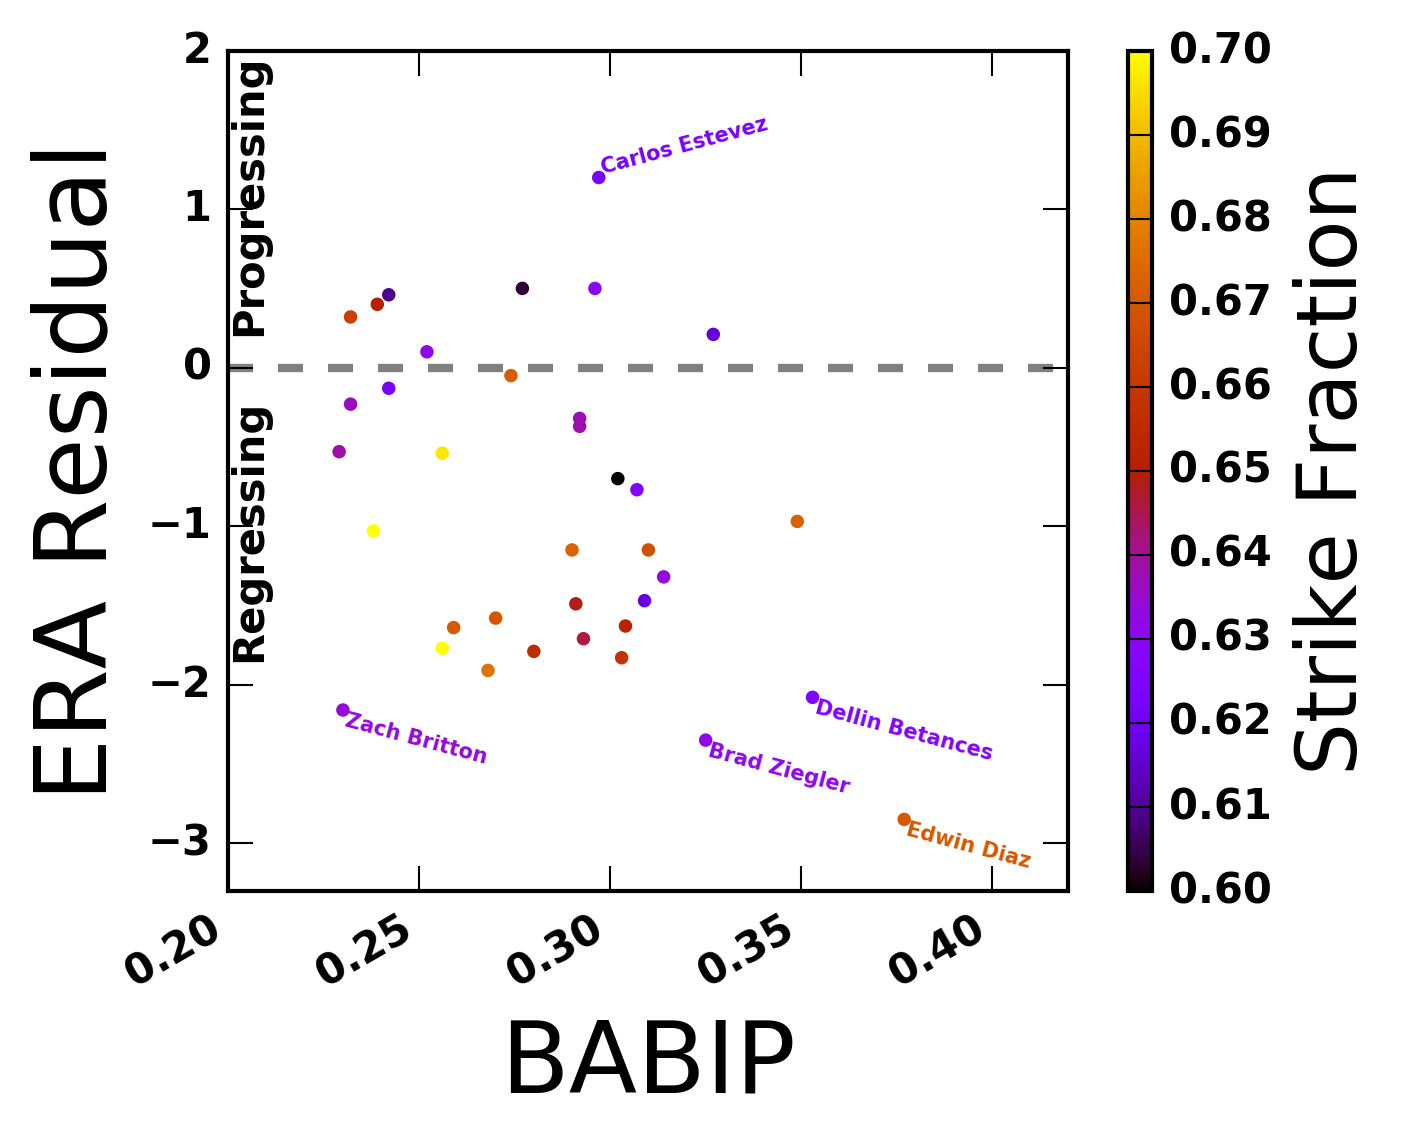

In [11]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['TSV'] > 8.)[0]



model = PlayerDict['ERA'][goodw] - d(PlayerDict['BABIP'][goodw])
cbar = ax.scatter(PlayerDict['BABIP'][goodw],model,\
                  color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

ax.plot([0.20,0.42],[0.,0.],color='gray',linestyle='dashed')

ax.axis([0.20,0.42,-3.3,2.0])
ax.set_xlabel('BABIP',size=24)
ax.set_ylabel('ERA Residual',size=24)
ax.text(0.20,-0.2,'Regressing',rotation=90,va='top')
ax.text(0.20,0.2,'Progressing',rotation=90,va='bottom')

for indx in goodw:
    modval = PlayerDict['ERA'][indx] - d(PlayerDict['BABIP'][indx])
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval > 0.9):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx]-0.6)/0.1,1.))
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval < -2.):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=-15,ha='left',va='top',color=cm.gnuplot((PlayerDict['ST'][indx] -0.6)/0.1,1.))


cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

Quick hits on progression/regression:

1. From CBS Preseason: * __Carlos Estevez__ is focusing on simplifying his delivery to the plate in an effort to produce more consistency, Patrick Saunders of The Denver Post reports.
The high-octane right-hander set a Rockies' rookie record by amassing 11 saves last season, but things fell apart toward the end of the season as "Wild Thing" stumbled to the finish line with an ERA north of 5.00.*
2. **Zach Britton** is on my team, and also the DL. Because of those circumstances, I will refrain from saying anything about him.
3. **Brad Ziegler** throws a ton of sinkers--and not very hard. How was he so successful?
4. **Dellin Betances** once again finds himself in the position of 'potentially valuable fantasy asset should the Yankees tank'. He should regress a bit, but still be solid.
5. **Edwin Diaz** is still young and that BABIP is scary, but he should be better than he has been, particularly when taking his strike fraction into account.